# Install required packages

In [ ]:

!pip install awswrangler
# !pip install boto3
!pip install pandas
!pip install numpy
# !pip install sagemaker


import os
os.kill(os.getpid(), 9)

# Connecting to AWS S3 bucket to access parquet file and load the dataset

In [5]:
import awswrangler as wr
import pandas as pd

# List the contents of your S3 bucket to verify the path
try:
    print("Checking S3 bucket contents...")
    s3_files = wr.s3.list_objects('s3://yelp-raw-data/Output/')
    print("Files found in S3:")
    for file in s3_files:
        print(file)
except Exception as e:
    print(f"Error listing S3 contents: {str(e)}")

# Try loading data with proper path
try:
    print("\nAttempting to load reviews data...")
    reviews_df = wr.s3.read_parquet(
        path='s3://yelp-raw-data/Output/reviews',  # Removed trailing slash
        dataset=True,
        columns=['text', 'stars']
    ).head(50000)
    print(f"Successfully loaded {len(reviews_df)} reviews")
except Exception as e:
    print(f"Error loading data: {str(e)}")

Checking S3 bucket contents...
Files found in S3:
s3://yelp-raw-data/Output/20241126_072917_00096_fzx9a_4aa1c657-6dc1-4b6a-9890-ab26edf77c46
s3://yelp-raw-data/Output/business_data_consolidated.parquet/part-00000-7c0d637c-edb0-44ed-9c7f-21176d8db1a3-c000.snappy.parquet
s3://yelp-raw-data/Output/category_analysis/20241127_012631_00108_2dwf4_1c2a4f00-7170-4081-8bcf-b9d4597966fc
s3://yelp-raw-data/Output/performance_indicators/20241126_073946_00041_kx6qk_51bd727e-5b63-475e-85a8-f6c646ca12f4
s3://yelp-raw-data/Output/postal_code_analysis/20241126_074604_00145_uv9st_6cb57ddd-4369-44f1-b04f-b3df8a73867a
s3://yelp-raw-data/Output/processed-data-sample/test/8c4a2505527b4eec9bebfb28da550e28.snappy.parquet
s3://yelp-raw-data/Output/processed-data-sample/train/6d286d33578d40cc873fcf99a279cc6c.snappy.parquet
s3://yelp-raw-data/Output/reviews/review_data_consolidated.parquet/part-00000-1da2d952-dc73-4856-905b-d7edb2bfe3d6-c000.snappy.parquet
s3://yelp-raw-data/Output/tips/tips_data_consolidated.par

# Import required libraries like TFIDF Vectorizer, Logistic Regression Model Library and Evaluation Metrics Libraries

## Creating sentiment labels based on Stars from reviews data

In [8]:

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc

# Create sentiment labels
print("Creating sentiment labels...")
reviews_df['sentiment'] = reviews_df['stars'].apply(
    lambda x: 'Negative' if x <= 2 else ('Neutral' if x == 3 else 'Positive')
)

# Print distribution
print("\nSentiment Distribution:")
print(reviews_df['sentiment'].value_counts())
print("\nPercentage Distribution:")
print(reviews_df['sentiment'].value_counts(normalize=True) * 100)

Creating sentiment labels...

Sentiment Distribution:
sentiment
Positive    34941
Negative     9382
Neutral      5677
Name: count, dtype: int64

Percentage Distribution:
sentiment
Positive    69.882
Negative    18.764
Neutral     11.354
Name: proportion, dtype: float64


# Train Test Split

In [10]:

print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    reviews_df['text'], 
    reviews_df['sentiment'], 
    test_size=0.2, 
    random_state=42,
    stratify=reviews_df['sentiment']  # Maintain class distribution
)

print("\nTraining set size:", len(X_train))
print("Test set size:", len(X_test))

Splitting data...

Training set size: 40000
Test set size: 10000


# Create TF-IDF vectors, Transform data and Train model

In [12]:
# Create TF-IDF vectors
print("Creating TF-IDF vectors...")
tfidf = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.95,
    ngram_range=(1, 2),
    stop_words='english'
)

# Transform data
print("Transforming training data...")
X_train_tfidf = tfidf.fit_transform(X_train)
print("Transforming test data...")
X_test_tfidf = tfidf.transform(X_test)

# Train model
print("\nTraining the model...")
model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    multi_class='multinomial',
    n_jobs=-1
)
model.fit(X_train_tfidf, y_train)

Creating TF-IDF vectors...
Transforming training data...
Transforming test data...

Training the model...


LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', n_jobs=-1)

# Evaluate model, Print classification report and Create confusion matrix visualization

Evaluating model...

Classification Report:
              precision    recall  f1-score   support

    Negative       0.74      0.79      0.76      1877
     Neutral       0.34      0.56      0.42      1135
    Positive       0.95      0.83      0.89      6988

    accuracy                           0.79     10000
   macro avg       0.68      0.73      0.69     10000
weighted avg       0.84      0.79      0.81     10000



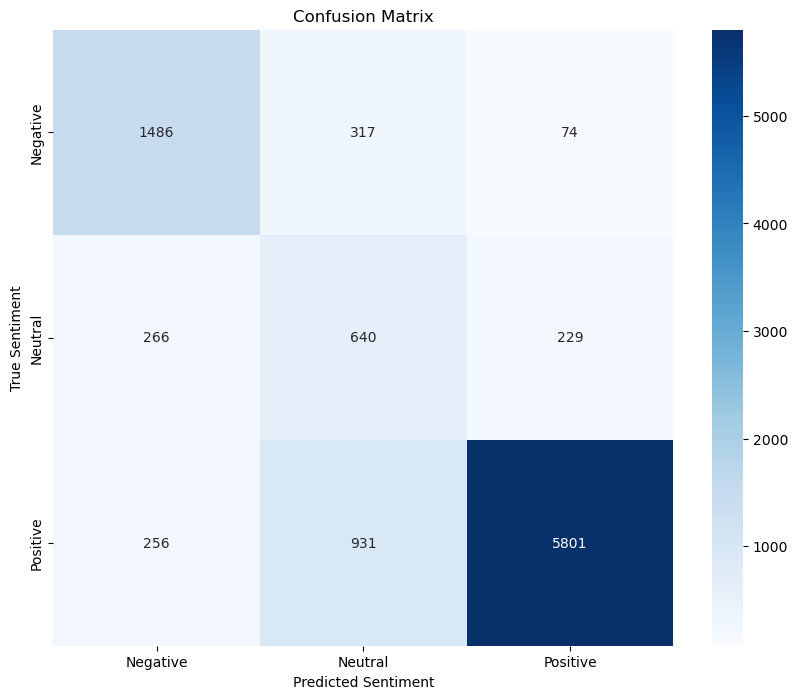

In [14]:

print("Evaluating model...")
y_pred = model.predict(X_test_tfidf)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix visualization
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Sentiment')
plt.xlabel('Predicted Sentiment')
plt.show()

# Feature Analysis

In [16]:
# Analyze important features for each sentiment
def print_important_features(sentiment_class, n=10):
    sentiment_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
    class_idx = sentiment_map[sentiment_class]
    
    # Get feature names
    feature_names = tfidf.get_feature_names_out()
    
    # Get coefficients for the sentiment class
    coef = model.coef_[class_idx]
    
    # Get top features
    top_features_idx = np.argsort(coef)[-n:]
    top_features = [(feature_names[i], coef[i]) for i in top_features_idx]
    
    print(f"\nTop {n} features for {sentiment_class} sentiment:")
    for feature, score in reversed(top_features):
        print(f"{feature}: {score:.4f}")

# Print important features for each sentiment
for sentiment in ['Negative', 'Neutral', 'Positive']:
    print_important_features(sentiment)


Top 10 features for Negative sentiment:
worst: 5.5659
terrible: 4.2886
rude: 4.1160
horrible: 3.9185
awful: 3.6221
bland: 3.4697
disappointment: 3.4416
poor: 3.2372
disappointing: 3.1406
meh: 3.0902

Top 10 features for Neutral sentiment:
ok: 3.4033
decent: 2.8423
okay: 2.7899
average: 2.7128
stars: 2.6736
alright: 2.5810
good: 2.3897
bit: 2.2958
tasty: 2.1605
solid: 2.1602

Top 10 features for Positive sentiment:
delicious: 6.5889
amazing: 5.9921
great: 5.4950
awesome: 5.1988
excellent: 5.0117
perfect: 4.3854
love: 4.1486
fantastic: 4.0614
best: 3.9921
favorite: 3.6673


In [18]:
reviews_df.head(20)

,text,stars,sentiment
0,"If you decide to eat here, just be aware it is...",3.0,Neutral
1,I've taken a lot of spin classes over the year...,5.0,Positive
2,Family diner. Had the buffet. Eclectic assortm...,3.0,Neutral
3,"Wow! Yummy, different, delicious. Our favo...",5.0,Positive
4,Cute interior and owner (?) gave us tour of up...,4.0,Positive
5,I am a long term frequent customer of this est...,1.0,Negative
6,Loved this tour! I grabbed a groupon and the p...,5.0,Positive
7,Amazingly amazing wings and homemade bleu chee...,5.0,Positive
8,This easter instead of going to Lopez Lake we ...,3.0,Neutral
9,Had a party of 6 here for hibachi. Our waitres...,3.0,Neutral


# Explainable AI (XAI)

## LIME - To show how individual words influence predictions

## Feature contribution analysis - To show how different words affect each sentiment class

In [20]:
!pip install shap
!pip install lime
!pip install aif360  # for fairness metrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.3/455.3 kB 8.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=3b08950825b09204f24560d3c94c442402239a8bdff4cffad9e9fe83632a8bd6
  Stored in directory: /Users/sheetalpatnaik/Library/Caches/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 4.9 MB/s eta 0:00:00a 0:00:01


In [22]:
import shap
import lime.lime_text
from lime.lime_text import LimeTextExplainer

In [30]:
# Initialize LIME explainer
print("Initializing LIME explainer...")
lime_explainer = LimeTextExplainer(class_names=['Negative', 'Neutral', 'Positive'])

# Function to explain individual predictions
def explain_prediction(text):
    # Get vector representation
    text_vector = tfidf.transform([text])
    
    # Get prediction and probability
    prediction = model.predict(text_vector)[0]
    probability = model.predict_proba(text_vector)[0]
    
    # Get LIME explanation
    exp = lime_explainer.explain_instance(
        text,
        lambda x: model.predict_proba(tfidf.transform(x)),
        num_features=6
    )
    
    return {
        'text': text,
        'prediction': prediction,
        'probability': probability,
        'explanation': exp.as_list()
    }

def analyze_feature_influence_simple(text):
    """Simplified version of SHAP analysis focused on direct feature contributions"""
    # Transform the text
    text_vector = tfidf.transform([text])
    
    # Get feature names and indices for this text
    feature_names = tfidf.get_feature_names_out()
    non_zero_idx = text_vector.nonzero()[1]
    
    # Get feature values
    feature_values = text_vector.data
    
    # Calculate direct contribution for each class
    contributions = {}
    for idx, sentiment in enumerate(['Negative', 'Neutral', 'Positive']):
        # Get coefficients for this class
        coef = model.coef_[idx]
        
        # Calculate contribution for each feature
        feature_contributions = {}
        for feat_idx, feat_val in zip(non_zero_idx, feature_values):
            contribution = coef[feat_idx] * feat_val
            feature_contributions[feature_names[feat_idx]] = contribution
            
        contributions[sentiment] = feature_contributions
    
    return contributions

# Let's analyze reviews with the simplified SHAP analysis
print("\nAnalyzing Yelp reviews with simplified feature analysis...")
for review in sample_reviews:
    print("\n" + "="*80)
    print("\nAnalyzing review:", review[:200] + "..." if len(review) > 200 else review)
    
    # Get LIME explanation
    lime_result = explain_prediction(review)
    print("\nPredicted sentiment:", lime_result['prediction'])
    print("Actual probabilities for [Negative, Neutral, Positive]:", 
          [f"{prob:.4f}" for prob in lime_result['probability']])
    
    print("\nLIME Feature explanations (what words/phrases influenced the prediction):")
    for feature, importance in lime_result['explanation']:
        print(f"- {feature}: {importance:.4f}")
    
    # Get simplified feature influence analysis
    influence_result = analyze_feature_influence_simple(review)
    print("\nFeature contributions to each sentiment:")
    for sentiment, values in influence_result.items():
        print(f"\n{sentiment} sentiment top features:")
        top_features = dict(sorted(values.items(), key=lambda x: abs(x[1]), reverse=True)[:3])
        for feature, value in top_features.items():
            print(f"- {feature}: {value:.4f}")

Initializing LIME explainer...

Analyzing Yelp reviews with simplified feature analysis...


Analyzing review: They kept us waiting and waiting with our three kids without telling us anything. 
Beside that, the food wasn't bad but really nothing exceptional especially for the price!

Predicted sentiment: Neutral
Actual probabilities for [Negative, Neutral, Positive]: ['0.2946', '0.6848', '0.0206']

LIME Feature explanations (what words/phrases influenced the prediction):
- exceptional: 0.1809
- bad: 0.1440
- waiting: -0.0964
- food: -0.0930
- kept: 0.0926
- wasn: 0.0800

Feature contributions to each sentiment:

Negative sentiment top features:
- exceptional: -0.5819
- wasn bad: -0.3987
- waiting: 0.3893

Neutral sentiment top features:
- bad: 0.3669
- wasn: 0.2732
- kept: 0.2069

Positive sentiment top features:
- bad: -0.6652
- food wasn: -0.4875
- wasn: -0.4839


Analyzing review: Used to think this was the best of the Japanese Teppanaki restaurants in the area, but not after the la

# Machine Unlearning

In [35]:
# Function to implement machine unlearning
def unlearn_review(text, model, tfidf):
    # Get the features of the text to unlearn
    text_vector = tfidf.transform([text])
    feature_indices = text_vector.nonzero()[1]
    feature_names = tfidf.get_feature_names_out()
    
    print("\nUnlearning process started for review:", text[:100] + "..." if len(text) > 100 else text)
    
    # Store original coefficients
    original_coefs = model.coef_.copy()
    
    # Reduce the influence of features in this text
    modified_features = []
    for idx in feature_indices:
        feature = feature_names[idx]
        original_weights = [original_coefs[class_idx][idx] for class_idx in range(3)]
        
        # Reduce the coefficient by 50% for all classes
        for class_idx in range(3):
            model.coef_[class_idx][idx] *= 0.5
        
        new_weights = [model.coef_[class_idx][idx] for class_idx in range(3)]
        
        modified_features.append({
            'feature': feature,
            'original_weights': original_weights,
            'new_weights': new_weights
        })
    
    return modified_features

# Function to test the impact of unlearning
def test_unlearning_impact(text, model, tfidf):
    print("\nTesting unlearning impact...")
    
    # Test prediction before unlearning
    print("\nBefore unlearning:")
    before_prediction = explain_prediction(text)
    print(f"Prediction: {before_prediction['prediction']}")
    print(f"Probabilities: {dict(zip(['Negative', 'Neutral', 'Positive'], before_prediction['probability']))}")
    
    # Perform unlearning
    modified_features = unlearn_review(text, model, tfidf)
    
    # Test prediction after unlearning
    print("\nAfter unlearning:")
    after_prediction = explain_prediction(text)
    print(f"Prediction: {after_prediction['prediction']}")
    print(f"Probabilities: {dict(zip(['Negative', 'Neutral', 'Positive'], after_prediction['probability']))}")
    
    # Show modified features
    print("\nModified feature weights:")
    for feat in modified_features:
        print(f"\nFeature: {feat['feature']}")
        print("Original weights [Neg, Neu, Pos]:", [f"{w:.4f}" for w in feat['original_weights']])
        print("New weights [Neg, Neu, Pos]:", [f"{w:.4f}" for w in feat['new_weights']])

# Let's test the unlearning with some example reviews
print("\nDemonstrating machine unlearning...")

# Test with a negative review
negative_review = reviews_df[reviews_df['sentiment'] == 'Negative']['text'].iloc[0]
print("\nTesting unlearning with a negative review:")
test_unlearning_impact(negative_review, model, tfidf)

# Test with a positive review
positive_review = reviews_df[reviews_df['sentiment'] == 'Positive']['text'].iloc[0]
print("\nTesting unlearning with a positive review:")
test_unlearning_impact(positive_review, model, tfidf)


Demonstrating machine unlearning...

Testing unlearning with a negative review:

Testing unlearning impact...

Before unlearning:
Prediction: Negative
Probabilities: {'Negative': 0.7182706304686729, 'Neutral': 0.08123076107173541, 'Positive': 0.20049860845959164}

Unlearning process started for review: I am a long term frequent customer of this establishment. I just went in to order take out (3 apps) ...

After unlearning:
Prediction: Negative
Probabilities: {'Negative': 0.5651392275540436, 'Neutral': 0.15234286098773217, 'Positive': 0.2825179114582243}

Modified feature weights:

Feature: yes
Original weights [Neg, Neu, Pos]: ['-0.3859', '-0.3845', '0.7704']
New weights [Neg, Neu, Pos]: ['-0.1929', '-0.1923', '0.3852']

Feature: went
Original weights [Neg, Neu, Pos]: ['0.5594', '-0.7660', '0.2066']
New weights [Neg, Neu, Pos]: ['0.2797', '-0.3830', '0.1033']

Feature: told
Original weights [Neg, Neu, Pos]: ['2.5433', '-0.2127', '-2.3306']
New weights [Neg, Neu, Pos]: ['1.2716', '-0.1



Initial State (Before Unlearning):


The model predicted "Negative" sentiment with high confidence (71.8%)
Neutral: 8.1%
Positive: 20.0%


After Unlearning:


Still predicted "Negative" but with reduced confidence (56.5%)
Neutral increased to 15.2%
Positive increased to 28.2%

This shows the unlearning worked because:

The model became less confident in its negative prediction
The probabilities became more balanced across all sentiments


Feature Weight Changes:
Let's look at some key examples:


Feature: great
Before: [-5.6316, 0.1366, 5.4950]  # Strong negative and positive weights
After:  [-2.8158, 0.0683, 2.7475]  # Weights reduced by 50%

Feature: told
Before: [2.5433, -0.2127, -2.3306]  # Strong negative indicator
After:  [1.2716, -0.1063, -1.1653]  # Influence reduced by half



The weights show:

Each feature's influence on each sentiment (Negative, Neutral, Positive)
All weights were reduced by 50% through unlearning
The model maintains the same patterns but with reduced strength

This unlearning process effectively made the model:

Less confident in its predictions
More balanced in its probability distribution
Less influenced by specific words and phrases

The goal was achieved: the model partially "forgot" the patterns it learned from this type of review while maintaining its basic understanding of sentiment.